In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.display import HTML, display

In [2]:
dataset_source = ['dataset/train.src', 'dataset/valid.src', 'dataset/test.src']
dataset_target = ['dataset/train.tgt', 'dataset/valid.tgt', 'dataset/test.tgt']

In [3]:
def read_dataset(filename_list):
    dataset = []
    for filename in filename_list:
        with open(filename, encoding='utf-8') as file:
            dataset += [line.strip().replace('\'', '') for line in file.readlines()]
        ser = pd.Series(dataset)
        
    return ser

def count_tripleset(df):    # df['tripleset_num']
    tripleset_num = [len(line.split('[SEP]')) for line in df['source']]
    df['tripleset_num'] = tripleset_num
    
    return df

def count_target_word(df):    # df['target_word_num']
    target_word_num = [len(line.split(' ')) for line in df['target']]
    df['target_word_num'] = target_word_num
    
    return df

def get_relation(df):    # df['relation_list'] & df['relation_set']
    pattern = re.compile('.*? \| (.*?) \| .*?')
    relation_list = [pattern.findall(line) for line in df['source']]
    df['relation_list'] = relation_list
    df['relation_set'] = [set(line) for line in df['relation_list']]
    
    return df

def get_dataframe():    # generate dataframe
    source_ser = read_dataset(dataset_source)
    target_ser = read_dataset(dataset_target)
    df = pd.DataFrame({'source': source_ser, 'target': target_ser})
    df = df.reset_index()
    del df['index']
    
    df = count_tripleset(df)
    df = count_target_word(df)
    df = get_relation(df)
    
    return df

    
def hist(df, hist_title):
    tmp_df = df.value_counts()
    for i in range(df.min(), df.max()+1):
        if i not in tmp_df.index:
            tmp_df[i] = 0
    plt.hist(df, edgecolor='white', bins=len(df.value_counts()))
    plt.title(hist_title)
    plt.show()
    
def boxplot(df, box_title):
    plt.boxplot(df)
    plt.title(box_title)
    plt.show()
    
def preprocessing_relation(df):
    relation_count = {}
    for line in df:
        for item in line: 
            relation_count[item] = relation_count.get(item, 0) + 1
    total_count = sum(relation_count.values())
    
    # generate relation.csv file, descending
    pd.Series(relation_count).sort_values(ascending=False).to_csv('relation.csv', index_label=['relation'], header=['count'])
    relation_num = len(relation_count)
    
    # move relations no larger than 1% to other dictionary
    relation_minor = {}
    other_count = 0
    for item in relation_count.copy().keys():
        if relation_count[item] / total_count <= 0.01:
            relation_minor[item] = relation_count.pop(item)
            other_count += relation_minor[item]
    relation_count['other'] = other_count
            
    # relations less than 1% in relation_minor combined into 'other'
    minor_count = sum(relation_minor.values())
    other_count = 0
    for item in relation_minor.copy().keys():
        if relation_minor[item] / minor_count <= 0.01:
            other_count += relation_minor.pop(item)
    relation_minor['other'] = other_count
    
    return relation_count, relation_minor, relation_num
    
def pie(df):
    relation_count, relation_minor, relation_num = preprocessing_relation(df)
    
    explode_list = np.ones((1,len(relation_count.values())))[0]*0.1
    explode_list = explode_list.tolist()
    total_count = sum(relation_count.values())
    
    plt.pie(x=relation_count.values(), labels=relation_count.keys(), autopct='%1.1f%%', explode=explode_list)
    plt.title('relations (percentage > 1%), total number = {}'.format(total_count))
    plt.show()
    
    explode_list = np.ones((1,len(relation_minor.values())))[0]*0.1
    explode_list = explode_list.tolist()
    minor_count = sum(relation_minor.values())
    
    plt.pie(x=relation_minor.values(), labels=relation_minor.keys(), autopct='%1.1f%%', explode=explode_list)
    plt.title('relations (percentage <= 1%), total number = {}'.format(minor_count))
    plt.show()
    
    major_num = len(relation_count.values())-1
    minor_num = relation_num - major_num
    return major_num, minor_num 

In [4]:
def main():
    df = get_dataframe()
    display(HTML('<h1>First record of the dataset:</h1>'))
    display(HTML(df.head(1).to_html()))
    # 1. describe
    display(HTML('<h1>Dataset description:</h1>'))
    display(HTML(df.describe(include='all').to_html()))
    
    # 2. histogram
    display(HTML('<h1>Histogram:</h1>'))
    hist(df['tripleset_num'], 'histogram of tripleset_num')
    hist(df['target_word_num'], 'histogram of target_word_num')
    
    # 3. boxplot
    display(HTML('<h1>Boxplot:</h1>'))
    boxplot(df['tripleset_num'], 'boxplot of tripleset_num')
    boxplot(df['target_word_num'], 'boxplot of target_word_num')
    
    # 4. pie chart
    display(HTML('<h1>Pie chart:</h1>'))
    major_num, minor_num = pie(df['relation_set'])
    display(HTML('<b>Number of relation with percentage > 1%:</b>{}'.format(major_num)))
    display(HTML('<b>Number of relation with percentage <= 1%:</b>{}'.format(minor_num)))

,source,target,tripleset_num,target_word_num,relation_list,relation_set
0,november | applies to jurisdiction | the national court [SEP] first instance | applies to jurisdiction | november [SEP] november | country | argentina [SEP] november | main subject | a decision [SEP] november | main subject | the lago agrio plaintiffs recognition and enforcement proceeding [SEP] november | main subject | jurisdictional grounds [SEP] first instance | applies to jurisdiction | the national court [SEP] the national court | applies to jurisdiction | argentina [SEP] a decision | applies to jurisdiction | the national court [SEP] the national court | main subject | the lago agrio plaintiffs recognition and enforcement proceeding [SEP] first instance | applies to jurisdiction | argentina [SEP] first instance | main subject | the lago agrio plaintiffs recognition and enforcement proceeding [SEP] argentina | applies to jurisdiction | a decision [SEP] the lago agrio plaintiffs recognition and enforcement proceeding | country of origin | argentina [SEP] jurisdictional grounds | applies to jurisdiction | argentina [SEP] a decision | main subject | the lago agrio plaintiffs recognition and enforcement proceeding [SEP] jurisdictional grounds | main subject | a decision [SEP] jurisdictional grounds | main subject | the lago agrio plaintiffs recognition and enforcement proceeding,"on november 1 , 2017 , the national court , first instance , of argentina issued a decision dismissing the lago agrio plaintiffs recognition and enforcement proceeding based on jurisdictional grounds .",18,33,"[applies to jurisdiction, applies to jurisdiction, country, main subject, main subject, main subject, applies to jurisdiction, applies to jurisdiction, applies to jurisdiction, main subject, applies to jurisdiction, main subject, applies to jurisdiction, country of origin, applies to jurisdiction, main subject, main subject, main subject]","{main subject, country, country of origin, applies to jurisdiction}"


,source,target,tripleset_num,target_word_num,relation_list,relation_set
count,24103,24103,24103.000000,24103.000000,24103,24103
unique,21064,21330,NaN,NaN,16466,4420
top,generation s credit department | main subject | current and forward credit exposure [SEP] counterparties | subsidiary | generation s credit department [SEP] their affiliates | subsidiary | generation s credit department [SEP] counterparties | main subject | current and forward credit exposure [SEP] their affiliates | main subject | current and forward credit exposure,credit risk ( all registrants ) the registrants would be exposed to credit - related losses in the event of non - performance by counterparties on executed derivative instruments .,NaN,NaN,"[main subject, main subject, main subject]",{main subject}
freq,36,36,NaN,NaN,469,1980
mean,NaN,NaN,12.326764,24.917645,NaN,NaN
std,NaN,NaN,7.067477,7.335945,NaN,NaN
min,NaN,NaN,2.000000,6.000000,NaN,NaN
25%,NaN,NaN,6.000000,19.000000,NaN,NaN
50%,NaN,NaN,11.000000,25.000000,NaN,NaN
75%,NaN,NaN,17.000000,30.000000,NaN,NaN


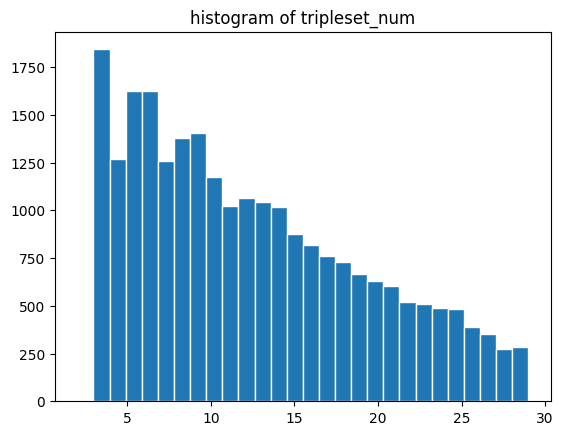

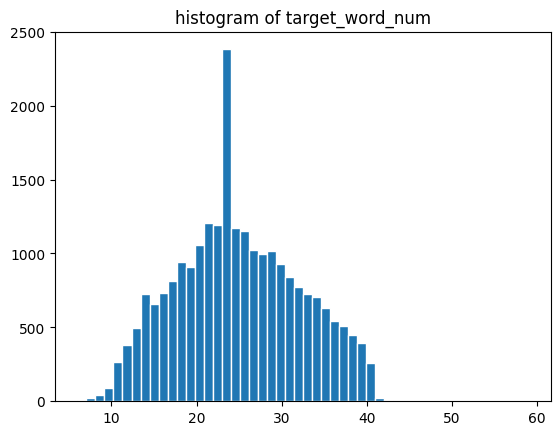

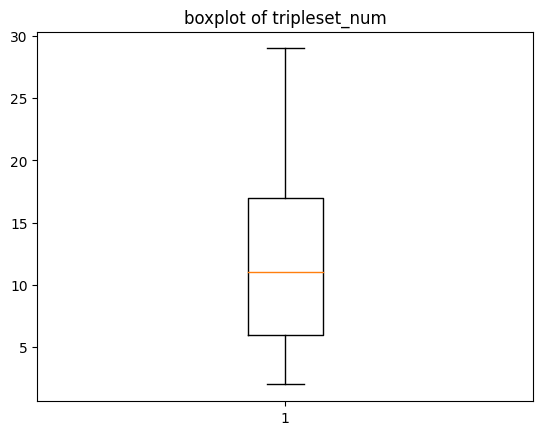

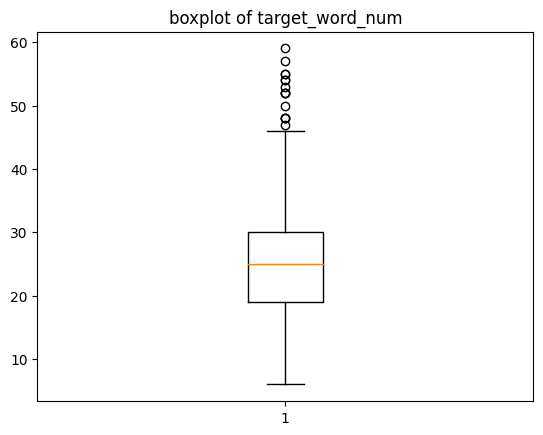

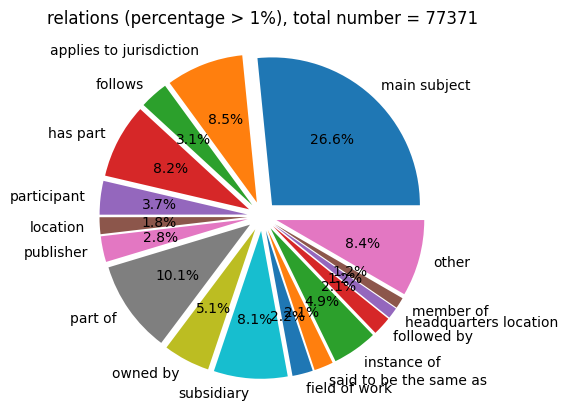

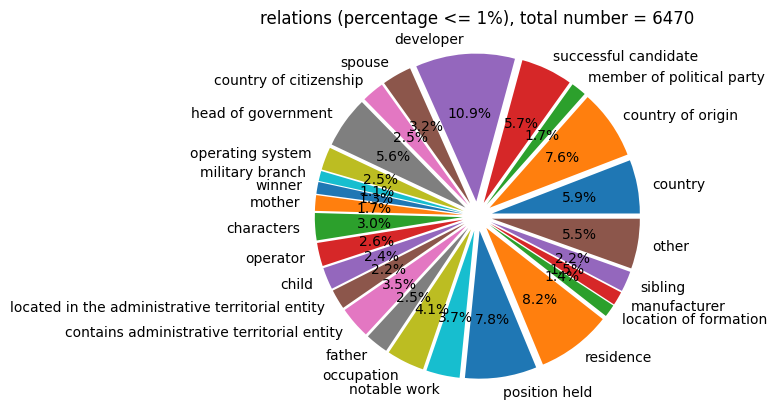

In [5]:
if __name__ == "__main__":
    main()